# Project task 01: Near duplicate detection with LSH

In [1]:
import gzip
import tarfile

import numpy as np
import pandas as pd
import time
import hashlib

from sklearn import preprocessing, metrics
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

To goal of this task is to find near duplicate songs in the Million Song dataset. You can imagine a scenario were the same song appears on multiple different releases with only small feature variation (e.g. duration or loudness).

## 1. Load data and extract the data

We'll be working with the Million Songs Dataset, a freely-available collection of audio features and metadata for a million contemporary popular music tracks.

Specifically, we will work with a smaller subset of 10 000 songs ([download link](http://static.echonest.com/millionsongsubset_full.tar.gz)).

In [2]:
tar = tarfile.open('millionsongsubset_full.tar.gz', 'r')
members = tar.getmembers()

In [3]:
tar.extract(members[5])
summary = pd.HDFStore(members[5].name)
songs = summary['/analysis/songs']

Show a snippet of how the data looks like:

In [4]:
songs.head()

,analysis_sample_rate,audio_md5,danceability,duration,end_of_fade_in,energy,idx_bars_confidence,idx_bars_start,idx_beats_confidence,idx_beats_start,...,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tempo,time_signature,time_signature_confidence,track_id
0,22050,a600d65cf157a306be60f26ecbf218f4,0.0,280.21506,0.238,0.0,0,0,0,0,...,5,0.555,-3.306,1,0.500,275.528,173.205,5,0.120,TRACCVZ128F4291A8A
1,22050,c64d75b0588e5ab552ee94548b50a4fa,0.0,191.68608,0.000,0.0,0,0,0,0,...,0,0.501,-10.764,1,0.710,184.128,150.955,4,0.600,TRACCMH128F428E4CD
2,22050,0cadd310865701bb93ced1cd78e8910a,0.0,222.92853,0.000,0.0,0,0,0,0,...,1,0.329,-9.035,1,0.407,216.300,93.056,4,1.000,TRACCSW128F148C7C3
3,22050,14be4fc1170152c445b3be7b8d18dfec,0.0,278.38649,0.496,0.0,0,0,0,0,...,7,0.313,-23.095,1,0.387,278.386,127.113,1,0.446,TRACCXJ128F428F0CF
4,22050,1def5d8298e8cb29a188a5a7c0e9429a,0.0,89.15546,4.847,0.0,0,0,0,0,...,2,0.000,-20.359,1,0.000,79.203,90.660,3,0.524,TRACCVS12903D014F8


We should have $31$ columns and $10~000$ rows.

In [5]:
print(len(songs))

10000


Since not all features are important we are going to consider a subset of features (columns) that are relevant for duplicate detection.

We will also convert the pandas dataframe into a numpy array so it is easier to work with.

In [6]:
subset = songs[['duration', 'end_of_fade_in', 'key', 'loudness',
                'mode', 'start_of_fade_out', 'tempo', 'time_signature',]]

data_matrix = subset.values

Additionally we will standardize the data to have zero mean and unit variance as a preprocessing step.

In [7]:
scaled_data = preprocessing.scale(data_matrix)

## 2. Implementaion

Your task is to implement near duplicate detection using LSH with cosine similarity.
More specifically you have to:
* Generate duplicate **candidates** based on LSH with $b$ bands and $r$ rows per band
* Refine the candidates by computing the exact cosine distance
* Report all pairs/duplicates with cosine distance < $d$

Implement a function that computes the cosine distance between two rows (instances) in the data.

In [8]:
def cosine_distance(X, i, j):
    """Compute cosine distance between two rows of a data matrix.
    
    Parameters
    ----------
    X : np.array, shape [N, D]
        Data matrix.
    i : int
        Index of the first row.
    j : int
        Index of the second row.
        
    Returns
    -------
    d : float
        Cosine distance between the two rows of the data matrix.
        
    """
    d = None
    
    ### YOUR CODE HERE ###
    if i < X.shape[0] and j < X.shape[0]:
        d = metrics.pairwise.cosine_distances(np.reshape(X[i], (1,-1)), np.reshape(X[j], (1,-1)))
        d = np.reshape(d, (1))
        #d = 1 - np.dot(X[i],X[j])/ (np.linalg.norm(X[i])*np.linalg.norm(X[j]))
    return float(d)

Cosine distance between the 5-th and the 28-th instance

In [9]:
print('{:.4f}'.format(cosine_distance(scaled_data, 5, 28)))

0.7273


In [10]:
def LSH(X, b=8, r=32, d=0.3):
    """Find candidate duplicate pairs using LSH and refine using exact cosine distance.
    
    Parameters
    ----------
    X : np.array shape [N, D]
        Data matrix.
    b : int
        Number of bands.
    r : int
        Number of rows per band.
    d : float
        Distance treshold for reporting duplicates.
    
    Returns
    -------
    duplicates : {(ID1, ID2, d_{12}), ..., (IDX, IDY, d_{xy})}
        A set of tuples indicating the detected duplicates.
        Each tuple should have 3 elements:
            * ID of the first song
            * ID of the second song
            * The cosine distance between them
    
    n_candidates : int
        Number of detected candidate pairs.
        
    """
    np.random.seed(158)
    n_candidates = 0
    duplicates = set()

    ### YOUR CODE HERE ###
    #Hash functions for random projection (Cosine sim) --> b*r needed
    random_hash = np.random.randn(b*r, X.shape[1])
    
    #Signature matrix for the array
    signature_matrix = np.sign(random_hash.dot(X.T))
    
    #Using band b and row r do AND and OR operations to get candidates
    candidates = []
    for band in range(b):
        #Focus on the rows pertaining to the current band
        sub_signature_matrix = signature_matrix[band*r:band*r + r, :]
        #Create a dict with md5 hash as key and list of indices of docs that has to the same value
        hash_bucket_dict = {}
        for doc in range(sub_signature_matrix.shape[1]):
            doc_signature = sub_signature_matrix[:, doc]
            md5_hash_key = hashlib.md5(str(doc_signature).encode()).hexdigest()
            
            #add the hash digest as key to the hash bucket dictionary 
            if md5_hash_key in hash_bucket_dict.keys():
                hash_bucket_dict[md5_hash_key].append(doc)
            else:
                hash_bucket_dict[md5_hash_key] = [doc]
        
        #Populate candidate pairs using the dictionary
        for md5_hash_key, doc_list in hash_bucket_dict.items():
            if len(doc_list) > 1:
                ordered_pairs = [[a, b] for a in doc_list for b in doc_list if a < b]
                for pair in ordered_pairs:
                    if pair not in candidates:
                        candidates.append(pair)
        
    n_candidates = len(candidates)
    
    #Use candidates and exact cosine distance to get duplicates
    for cand in candidates:
        dist = cosine_distance(X, cand[0], cand[1])
        if dist <= d:
            duplicates.add((cand[0], cand[1], dist))
            
    return duplicates, n_candidates

In [11]:
duplicates, n_candidates = LSH(scaled_data, b=3, r=64, d=0.0003)

In [12]:
print('We detected {} candidates.'.format(n_candidates))

We detected 3860 candidates.


Show the duplicates we have found:

In [13]:
duplicates

{(70, 6427, 0.0002997386232331811),
 (99, 9651, 0.00027760147246058686),
 (612, 2569, 0.0),
 (3088, 5529, 0.00017364668134511874)}

Show the metadata for the songs that were detected as duplicates:

In [14]:
for i, j, d in duplicates:
    print('Song ID 1: {}'.format(i),
          'Song ID 2: {}'.format(j),
          'Distance: {:.6f}'.format(d),
          summary['/metadata/songs'].loc[i][['title', 'artist_name']].str.cat(sep=' - '),
          summary['/metadata/songs'].loc[j][['title', 'artist_name']].str.cat(sep=' - '), sep='\n')
    print()

Song ID 1: 99
Song ID 2: 9651
Distance: 0.000278
This Time I Know - Theodis Ealey
Would? - Alice In Chains

Song ID 1: 70
Song ID 2: 6427
Distance: 0.000300
The Flame - Chimaira
Pathfinders - Elvenking

Song ID 1: 3088
Song ID 2: 5529
Distance: 0.000174
Quiet Time - Regina Belle
Quiet Time - Regina Belle

Song ID 1: 612
Song ID 2: 2569
Distance: 0.000000
Mary Had A Little Lamb - Stevie Ray Vaughan And Double Trouble
Mary Had A Little Lamb - Stevie Ray Vaughan And Double Trouble



## 3. Compare runtime

Your task is to implement code for runtime comparison between LSH and the naive nested for loop implementation.

In [15]:
# naively compute the duplicates using a double for loop
def naive_duplicates(X, d = 0.2):
    """
    Parameters
    ----------
    X : np.array, shape [N, D]
        Data matrix.
    d : float
        Distance treshold for reporting duplicates.
    
    Returns
    -------
    duplicates : {(ID1, ID2, d_{12}), ..., (IDX, IDY, d_{xy})}
        A set of tuples indicating the detected duplicates.
        Each tuple should have 3 elements:
            * ID of the first song
            * ID of the second song
            * The cosine distance between them
    """
    N = X.shape[0]
    duplicates = set()
    for i in range(N):
        for j in range(N):
            d_ij = cosine_distance(X, i, j)
            if d_ij < d and i != j:
                duplicates.add((i, j, d_ij))
    return duplicates

In [16]:
def runtime_comparison():
    """
    Compare the runtime between LSH and the naive approach.
    
    Returns
    -------
    trace : [(n1, lsh_dur, naive_dur), (n2, lsh_dur, naive_dur), ... ]
            A list of tuples with execution times for different number of songs.
            Each tuple should have 3 elements:
                * number of songs considered
                * duration of the LSH approach
                * duration of the naive approach
    """
    trace = []
    for n in np.arange(25, 251, 25):
        print('Running comparison for {} songs.'.format(n))
        
        ### YOUR CODE HERE ###
        start = time.time()
        LSH(scaled_data[0:n,:],b=3, r=64, d=0.0003)
        end = time.time()
        lsh_dur = end - start
        
        start = time.time()
        naive_duplicates(scaled_data[0:n,:], d=0.0003)
        end = time.time()
        naive_dur = end - start
        
        trace.append([n, lsh_dur, naive_dur])
    return trace

In [17]:
trace = runtime_comparison()

Running comparison for 25 songs.
Running comparison for 50 songs.
Running comparison for 75 songs.
Running comparison for 100 songs.
Running comparison for 125 songs.
Running comparison for 150 songs.
Running comparison for 175 songs.
Running comparison for 200 songs.
Running comparison for 225 songs.
Running comparison for 250 songs.


Plot the differecene in runtime. On the x-axis plot the number of songs processed and on the y-axis plot the runtime in seconds for both approaches. You should obtain a plot similar to the one shown below.

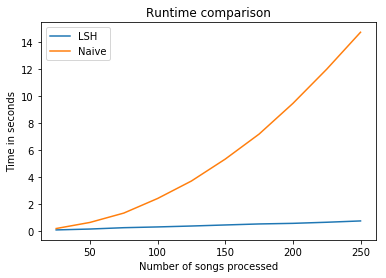

In [18]:
### YOUR PLOTTING CODE HERE ###
tr = np.array(trace)
x = tr[:,0]
y1 = tr[:,1]
y2 = tr[:,2]
plt.plot(x,y1, label='LSH')
plt.plot(x,y2, label='Naive')
plt.xlabel("Number of songs processed")
plt.ylabel("Time in seconds")
plt.title("Runtime comparison")
plt.legend()